# Описание набора данных

Этот синтетически сгенерированный набор данных включает различные связанные с погодой характеристики и классифицирует погоду по четырем типам: **дождливая**, **солнечная**, **облачная** и **снежная**.

| Признак              | Вид            | Описание                                                         |
|----------------------|----------------|------------------------------------------------------------------|
| Temperature          | Числовой       | Температура в градусах Цельсия                                   |
| Humidity             | Числовой       | Процент влажности                                                |
| Wind Speed           | Числовой       | Скорость ветра (км/ч)                                            |
| Precipitation (%)    | Числовой       | Процент осадков                                                  |
| Cloud Cover          | Категориальный | Описание облачного покрова                                       |
| Atmospheric Pressure | Числовой       | Атмосферное давление (гПа)                                       |
| UV Index             | Числовой       | УФ-индекс, указывающий интенсивность ультрафиолетового излучения |
| Season               | Категориальный | Сезон, в течение которого были записаны данные                   |
| Visibility (km)      | Числовой       | Видимость (км)                                                   |
| Location             | Категориальный | Тип местоположения, где были записаны данные                     |
| **Weather Type**     | Категориальный | Целевая переменная для классификации, указывающая тип погоды     |



# Предварительная обработка данных

Импортируем библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Загрузим данные в датафрейм

In [2]:
df = pd.read_csv('weather_classification_data.csv')
df

Temperature  Humidity  Wind Speed  Precipitation (%)    Cloud Cover  \
0             14.0        73         9.5               82.0  partly cloudy   
1             39.0        96         8.5               71.0  partly cloudy   
2             30.0        64         7.0               16.0          clear   
3             38.0        83         1.5               82.0          clear   
4             27.0        74        17.0               66.0       overcast   
...            ...       ...         ...                ...            ...   
13195         10.0        74        14.5               71.0       overcast   
13196         -1.0        76         3.5               23.0         cloudy   
13197         30.0        77         5.5               28.0       overcast   
13198          3.0        76        10.0               94.0       overcast   
13199         -5.0        38         0.0               92.0       overcast   

       Atmospheric Pressure  UV Index  Season  Visibility (km)  Location  \
0                   1010.82         2  Winter              3.5    inland   
1                   1011.43         7  Spring             10.0    inland   
2                   1018.72         5  Spring              5.5  mountain   
3                   1026.25         7  Spring              1.0   coastal   
4                    990.67         1  Winter              2.5  mountain   
...                     ...       ...     ...              ...       ...   
13195               1003.15         1  Summer              1.0  mountain   
13196               1067.23         1  Winter              6.0   coastal   
13197               1012.69         3  Autumn              9.0   coastal   
13198                984.27         0  Winter              2.0    inland   
13199               1015.37         5  Autumn             10.0  mountain   

      Weather Type  
0            Rainy  
1           Cloudy  
2            Sunny  
3            Sunny  
4            Rainy  
...            ...  
13195        Rainy  
13196        Snowy  
13197       Cloudy  
13198        Snowy  
13199        Rainy  

[13200 rows x 11 columns]

Проверим, есть ли в датасете пропуски или дубликаты

In [3]:
df.isnull().any()

Temperature             False
Humidity                False
Wind Speed              False
Precipitation (%)       False
Cloud Cover             False
Atmospheric Pressure    False
UV Index                False
Season                  False
Visibility (km)         False
Location                False
Weather Type            False
dtype: bool

In [4]:
df.duplicated().any()

False

В данных нет пропущенных или дублирующихся значений

Количество уникальных значений каждого столбца:

In [5]:
df.nunique()

Temperature              126
Humidity                  90
Wind Speed                97
Precipitation (%)        110
Cloud Cover                4
Atmospheric Pressure    5456
UV Index                  15
Season                     4
Visibility (km)           41
Location                   3
Weather Type               4
dtype: int64

Основные статистики для числовых признаков:

In [6]:
df.describe()

Temperature      Humidity    Wind Speed  Precipitation (%)  \
count  13200.000000  13200.000000  13200.000000       13200.000000   
mean      19.127576     68.710833      9.832197          53.644394   
std       17.386327     20.194248      6.908704          31.946541   
min      -25.000000     20.000000      0.000000           0.000000   
25%        4.000000     57.000000      5.000000          19.000000   
50%       21.000000     70.000000      9.000000          58.000000   
75%       31.000000     84.000000     13.500000          82.000000   
max      109.000000    109.000000     48.500000         109.000000   

       Atmospheric Pressure      UV Index  Visibility (km)  
count          13200.000000  13200.000000     13200.000000  
mean            1005.827896      4.005758         5.462917  
std               37.199589      3.856600         3.371499  
min              800.120000      0.000000         0.000000  
25%              994.800000      1.000000         3.000000  
50%             1007.650000      3.000000         5.000000  
75%             1016.772500      7.000000         7.500000  
max             1199.210000     14.000000        20.000000

Можем заметить аномальные значение 109 для температуры, процента влажности и процента осадков, а также нереалистичные минимальные  и максимальные показатели атмосферного давления - такие значение являются выбросами, поскольку не представляют собой реальные данные.

Эти наблюдения стоит сразу исключить из рассмотрения. Для температуры примем максимальную границу за 56,7 градусов, для процента влажности 95% и процента осадков 100%. Значения атмосферного давление оставим в диапазоне 850-1085.6 гПа.

In [7]:
df = df[(df['Temperature'] <= 56.7) & (df['Humidity'] <= 95) & (df['Precipitation (%)'] <= 100)
& (df['Atmospheric Pressure'] >= 850) & (df['Atmospheric Pressure'] <= 1085.6)].reset_index(drop=True)
len(df)

11143

Теперь данные соответветсвуют минимальным и максимальным зарегистрированным показателям на Земле, а количество значений все еще достаточно для полноценного анализа

Для удобства дальнейшей работы, вынесем названия числовых и категориальных признаков в разные переменные

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11143 entries, 0 to 11142
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           11143 non-null  float64
 1   Humidity              11143 non-null  int64  
 2   Wind Speed            11143 non-null  float64
 3   Precipitation (%)     11143 non-null  float64
 4   Cloud Cover           11143 non-null  object 
 5   Atmospheric Pressure  11143 non-null  float64
 6   UV Index              11143 non-null  int64  
 7   Season                11143 non-null  object 
 8   Visibility (km)       11143 non-null  float64
 9   Location              11143 non-null  object 
 10  Weather Type          11143 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 957.7+ KB


In [9]:
num = df.select_dtypes(include=['number']).columns
cat = df.select_dtypes(include=['object']).columns

Построим гистограммы распределения для числовых признаков

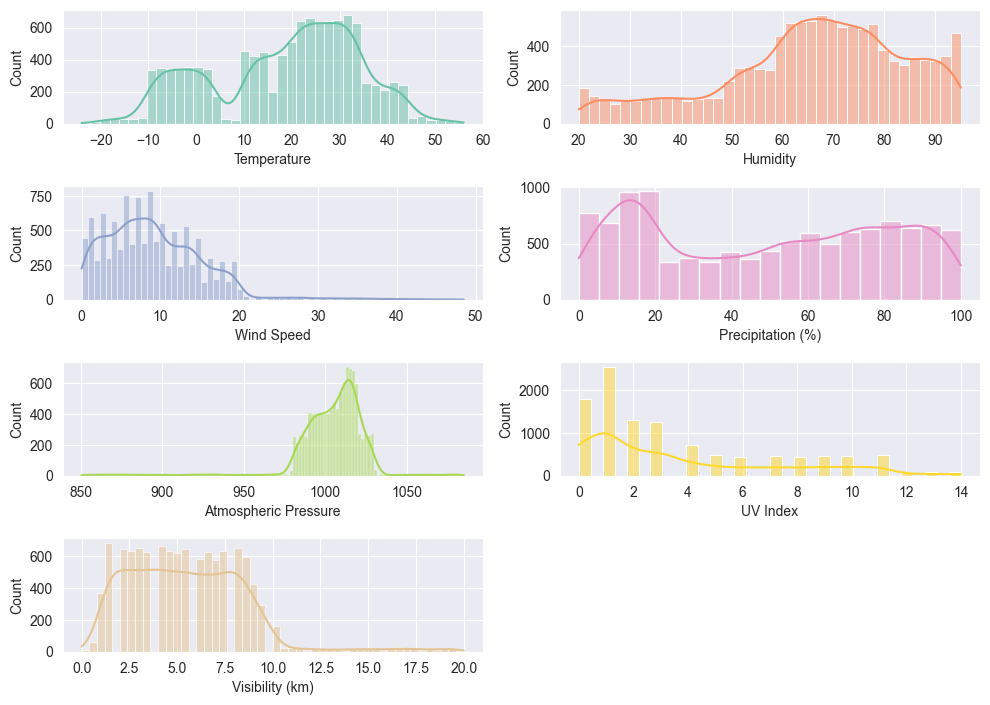

In [10]:
color_palette = sns.color_palette('Set2').as_hex()

plt.figure(figsize=(10, 12))
for i, col in enumerate(num):
  plt.subplot(len(num), 2, i + 1)
  sns.histplot(data=df, x=col, kde=True, color=color_palette[i])
plt.tight_layout()

Значения признаков распределены асимметрично, некоторые из них имеют длинные хвосты, что говорит о наличии значений, существенно отклоняющихся от средних

Также посмотрим на ящики с усами (boxplot)

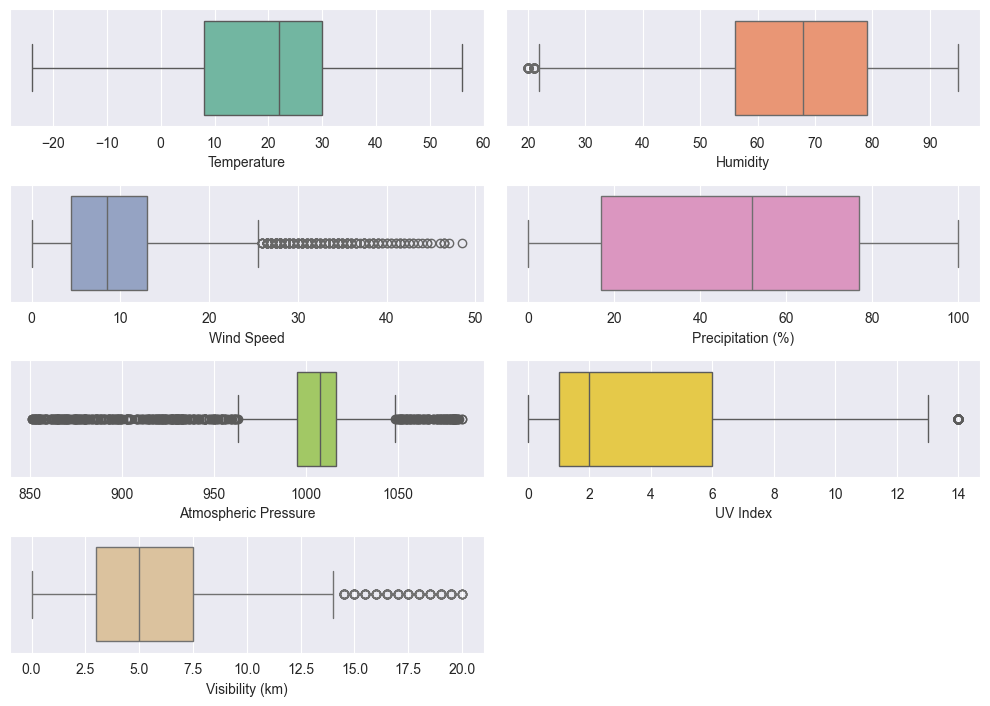

In [11]:
plt.figure(figsize=(10, 12))
for i, col in enumerate(num):
  plt.subplot(len(num), 2, i + 1)
  sns.boxplot(data=df, x=col, color=color_palette[i])
plt.tight_layout()

Мы все еще наблюдаем выбросы в данных, однако имеет смысл оставить эти наблюдения, поскольку они могут нести информацию о специфических погодных условиях

Также, очевидно, рассматриваемые величины имеют разный порядок. Проведем масштабирование числовых признаков с помощью `StandardScaler`

In [12]:
scaler = StandardScaler()
df[num] = scaler.fit_transform(df[num])
df[num]

Temperature  Humidity  Wind Speed  Precipitation (%)  \
0        -0.298588  0.399147    0.050630           1.059192   
1         0.743778 -0.095891   -0.350745          -1.059595   
2         1.264961  0.949188   -1.233769           1.059192   
3         0.548334  0.454151    1.254754           0.545546   
4         0.874073 -0.590928   -0.912669          -0.738567   
...            ...       ...         ...                ...   
11138    -0.559179  0.454151    0.853380           0.706060   
11139    -1.275806  0.564159   -0.912669          -0.834875   
11140     0.743778  0.619163   -0.591569          -0.674361   
11141    -1.015214  0.564159    0.130905           1.444425   
11142    -1.536397 -1.525999   -1.474594           1.380220   

       Atmospheric Pressure  UV Index  Visibility (km)  
0                  0.294197 -0.475395        -0.636539  
1                  0.634213  0.353651         0.002754  
2                  0.958305  0.906347        -1.435655  
3                 -0.573060 -0.751743        -0.956186  
4                  0.260195 -0.475395        -0.157069  
...                     ...       ...              ...  
11138             -0.035920 -0.751743        -1.435655  
11139              2.722085 -0.751743         0.162577  
11140              0.374682 -0.199046         1.121517  
11141             -0.848516 -1.028091        -1.116009  
11142              0.490029  0.353651         1.441163  

[11143 rows x 7 columns]

Основные статистики для категориальных признаков:

In [13]:
df[cat].describe()

Cloud Cover  Season  Location Weather Type
count        11143   11143     11143        11143
unique           4       4         3            4
top       overcast  Winter  mountain       Cloudy
freq          5078    4726      4106         2921

Построим графики для подсчета значений категориальных признаков

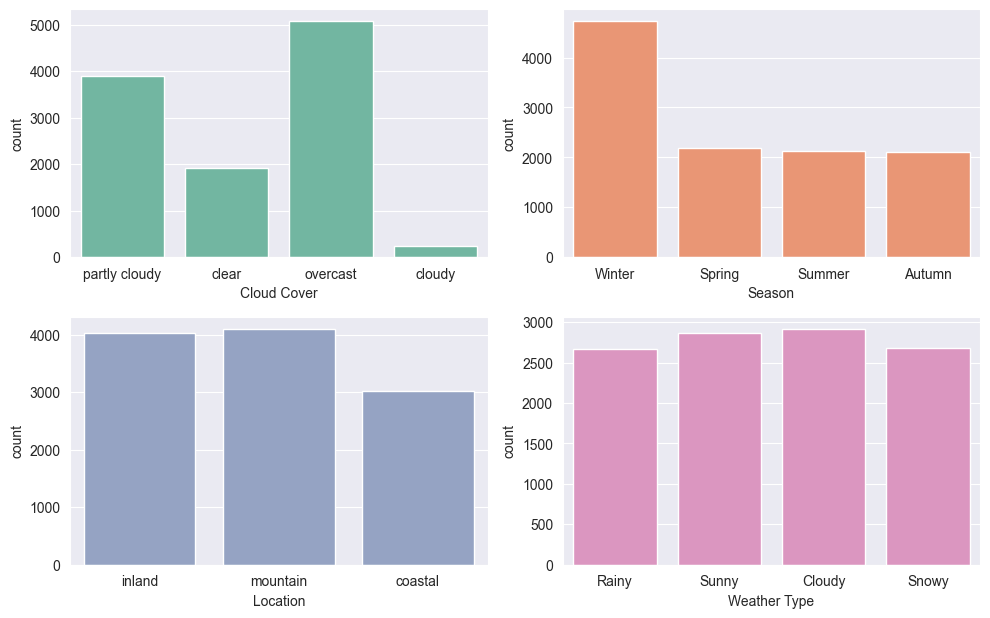

In [14]:
plt.figure(figsize=(10, 12))
for i, col in enumerate(cat):
  plt.subplot(len(cat), 2, i + 1)
  sns.countplot(data=df, x=col, color=color_palette[i])
plt.tight_layout()

Видим, что категориальные признаки `Cloud Cover`, `Season` и `Location` имеют дисбаланс, связанный с особенностями собранных данных, а также их вероятностью в природе.

Однако целевая переменная **`Weather Type`** содержит похожее количество наблюдений для каждого из 4 возможных типов погоды.

Отобразим конкретное количество:

In [15]:
df['Weather Type'].value_counts()

Weather Type
Cloudy    2921
Sunny     2868
Snowy     2684
Rainy     2670
Name: count, dtype: int64

Действительно, для каждого типа погоды насчитывается от 2670 до 2921 наблюдений. Классы довольно сбалансированы, что хорошо для решения задачи классификации

Посмотрим наконец на взаимосвязи между всеми признаками

<Figure size 1400x1400 with 0 Axes>

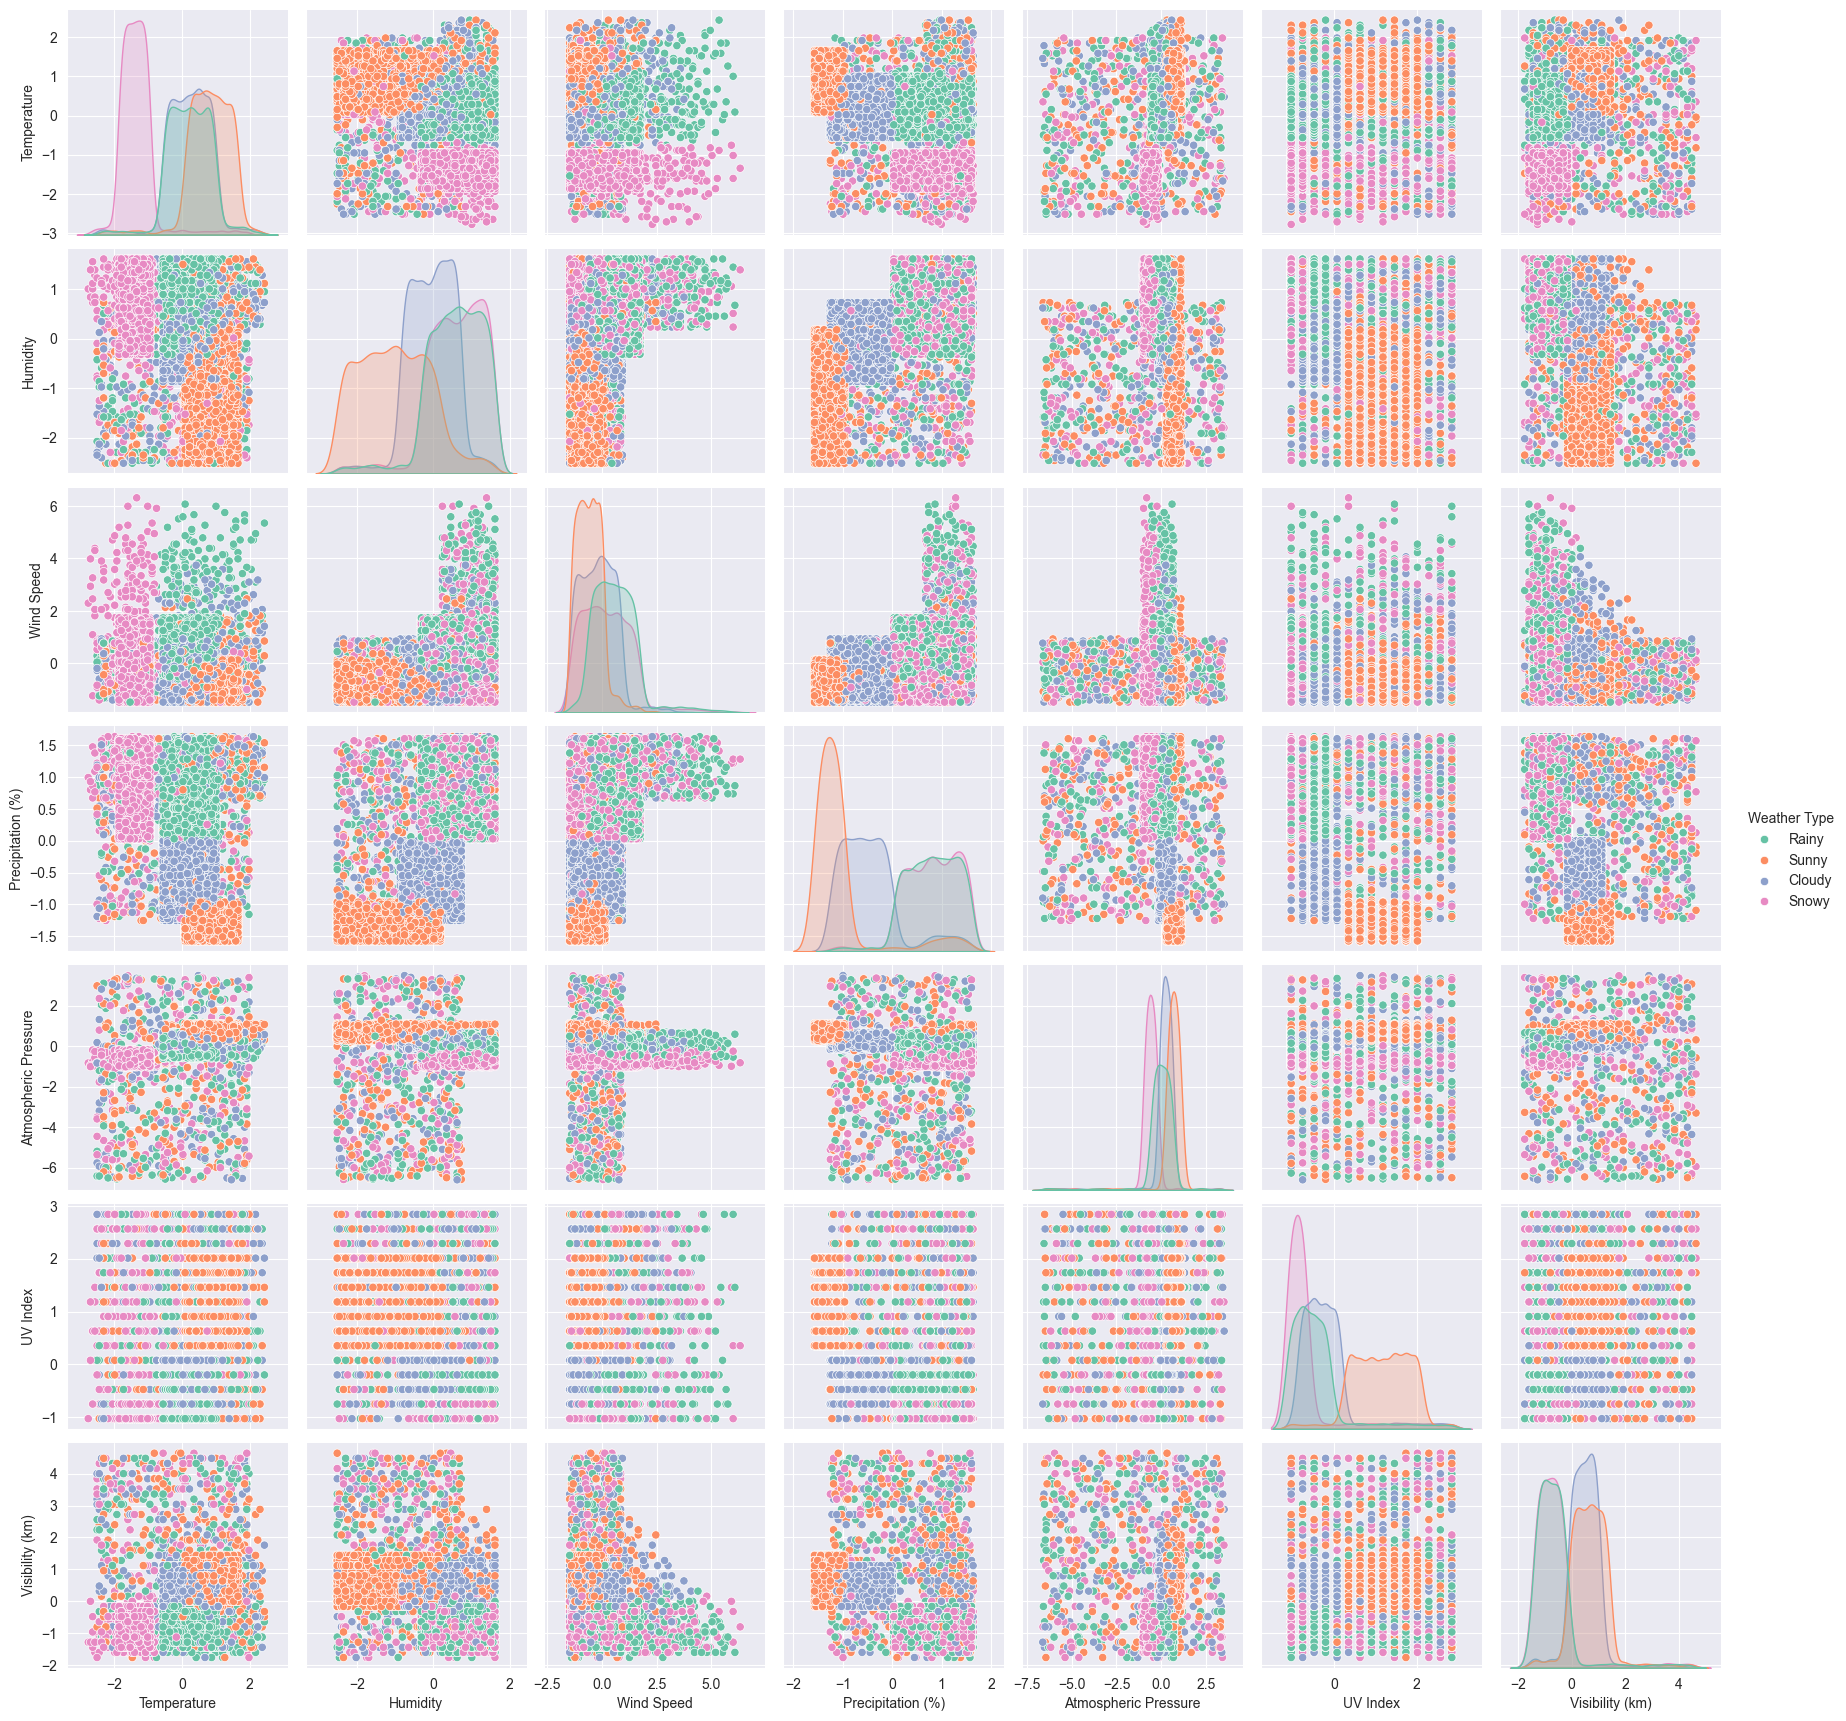

In [16]:
plt.figure(figsize=(14, 14))
sns.pairplot(df, hue='Weather Type', palette=color_palette[:4])
plt.show()

 Сильных взаимосвязей между числовыми признаками не прослеживается, однако можно заметить некоторые скопления данных для разных типов погоды.

 Наиболее наглядно это видно на графика зависимости температуры и процента осадков:

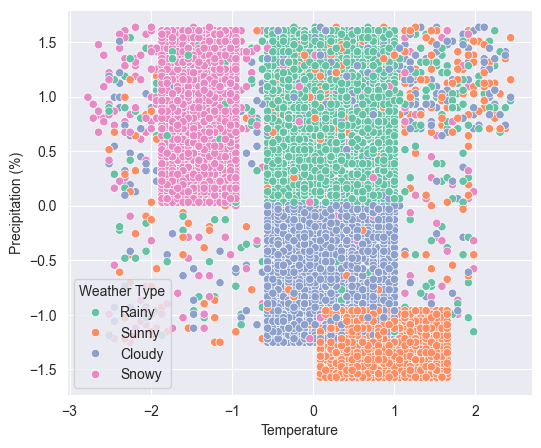

In [17]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df, x='Temperature', y='Precipitation (%)', hue='Weather Type', palette=color_palette[:4])
plt.show()

Для дальнейшей работы с данными будет не лишним преобразовать категориальные признаки к числовым значениям с помощью `LabelEncoder`

In [18]:
label_encoder = LabelEncoder()
for feature in cat[:3]:
  df[feature] = label_encoder.fit_transform(df[feature])
df[cat]

Cloud Cover  Season  Location Weather Type
0                3       3         1        Rainy
1                0       1         2        Sunny
2                0       1         0        Sunny
3                2       3         2        Rainy
4                2       2         1       Cloudy
...            ...     ...       ...          ...
11138            2       2         2        Rainy
11139            1       3         0        Snowy
11140            2       0         0       Cloudy
11141            2       3         1        Snowy
11142            2       0         2        Rainy

[11143 rows x 4 columns]

Теперь, подготовив все данные и определив, что они неплохо делятся на классы, можем идти дальше.

# Постановка задачи и построение модели

Наша задача - построить несколько моделей для классификации на один из 4 типов погоды (дождливая, солнечная, облачная и снежная) по прочим погодным данным, а затем сравнить результаты и выбрать лучшую модель

Разделим набор данных на тестовую и обучающую выборки в соотношении `test_size=0.2`

In [19]:
X = df.drop(columns=['Weather Type'])
y = df['Weather Type']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=28)
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (8357, 10) (8357,)
Test: (2786, 10) (2786,)


Выделим несколько моделей-классификаторов для обучения:

In [21]:
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=28),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=28),
    'Decision Tree': DecisionTreeClassifier(random_state=28),
    'Random Forest': RandomForestClassifier(random_state=28),
    'Gradient Boosting': GradientBoostingClassifier(random_state=28),
}

Будем обучать следующие модели:


*   Логистическая регрессия
*   Наивный байесовский классификатор
*   Метод K-ближайших соседей
*   Метод опорных векторов
*   Дерево решений
*   Случайный лес
*   Градиентный бустинг



Обучим модели и посмотрим, какие результаты они показывают на тренировочных данных с помощью `classification_report`. Основной метрикой качества будет `accuracy_score` (точность).

In [22]:
results = {}

for model_name, model in classifiers.items():
    print(model_name)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_train)

    accuracy = accuracy_score(y_train, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    print('Classification report:')
    print(classification_report(y_train, y_pred))
    print('\n')

    results[model_name] = clf

Logistic Regression
Accuracy: 0.9088
Classification report:
              precision    recall  f1-score   support

      Cloudy       0.90      0.90      0.90      2197
       Rainy       0.89      0.91      0.90      2002
       Snowy       0.93      0.94      0.94      1994
       Sunny       0.92      0.89      0.90      2164

    accuracy                           0.91      8357
   macro avg       0.91      0.91      0.91      8357
weighted avg       0.91      0.91      0.91      8357



Naive Bayes
Accuracy: 0.9101
Classification report:
              precision    recall  f1-score   support

      Cloudy       0.93      0.88      0.90      2197
       Rainy       0.88      0.90      0.89      2002
       Snowy       0.94      0.94      0.94      1994
       Sunny       0.90      0.92      0.91      2164

    accuracy                           0.91      8357
   macro avg       0.91      0.91      0.91      8357
weighted avg       0.91      0.91      0.91      8357



KNN
Accuracy: 

Kлассификаторы Дерево решений, Случайный лес и «Градиентный бустинг достигают высочайшей точности (`accuracy`) и F-меры (`f1-score`), что указывает на их надежную работу, однако показатель accuracy = 1.00 для Дерева решений и Случайного леса может говорить и о переобучении.

Большинство классификаторов демонстрируют сбалансированную точность (`precision`) и полноту (`recall`) для разных классов, что позволяет предположить, что они хорошо определяют каждый тип погоды.

# Оценка модели и результатов

Проверим, как работают обученные модели на тестовых данных

In [23]:
final_results = {}

for model_name, model in results.items():
    print(model_name)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    print('Classification report:')
    print(classification_report(y_test, y_pred))
    print('\n')

    final_results[model_name] = accuracy

Logistic Regression
Accuracy: 0.9017
Classification report:
              precision    recall  f1-score   support

      Cloudy       0.89      0.90      0.89       724
       Rainy       0.88      0.89      0.89       668
       Snowy       0.92      0.95      0.94       690
       Sunny       0.92      0.87      0.89       704

    accuracy                           0.90      2786
   macro avg       0.90      0.90      0.90      2786
weighted avg       0.90      0.90      0.90      2786



Naive Bayes
Accuracy: 0.9038
Classification report:
              precision    recall  f1-score   support

      Cloudy       0.93      0.89      0.91       724
       Rainy       0.87      0.88      0.88       668
       Snowy       0.94      0.94      0.94       690
       Sunny       0.88      0.91      0.89       704

    accuracy                           0.90      2786
   macro avg       0.90      0.90      0.90      2786
weighted avg       0.90      0.90      0.90      2786



KNN
Accuracy: 

Сравним показатель точности моделей:

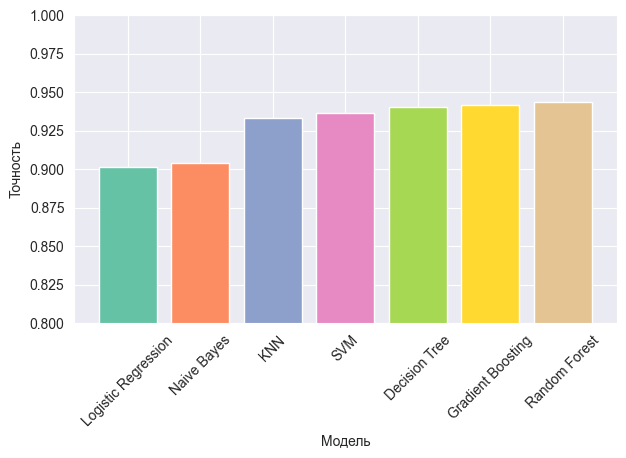

In [24]:
sorted_results = sorted(final_results.items(), key=lambda x: x[1])
x = [x[0] for x in sorted_results]
y = [x[1] for x in sorted_results]

plt.figure(figsize=(7, 4))
plt.bar(x, y, color=color_palette[:7])
plt.xlabel('Модель')
plt.ylabel('Точность')
plt.xticks(rotation=45)
plt.ylim(0.8, 1)
plt.show()

In [25]:
models_score = pd.DataFrame(data=y[::-1], index=x[::-1], columns=['Accuracy'])
print('Точность моделей:')
models_score

Точность моделей:


Accuracy
Random Forest        0.943288
Gradient Boosting    0.941852
Decision Tree        0.940416
SVM                  0.936109
KNN                  0.932879
Naive Bayes          0.903805
Logistic Regression  0.901651

Итак, наилучшим образом с классификацией справилась модель **Random Forest**, набрав точность 0.943. Однако другие модели также имеют хорошие результаты (не менее 0.902).

Построим матрицу ошибок для модели случайного леса

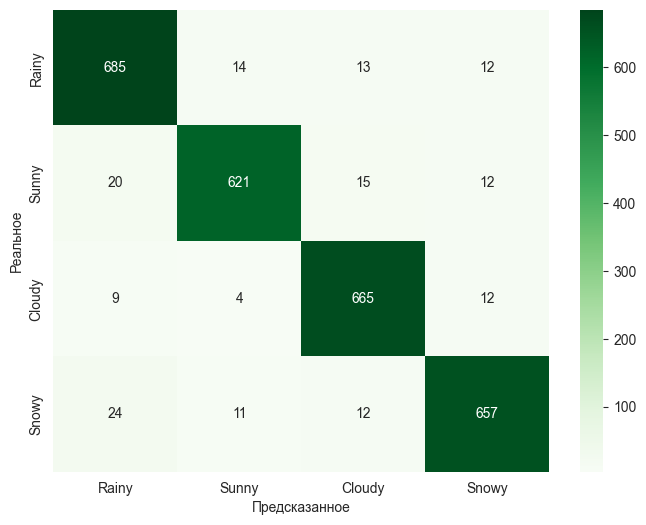

In [26]:
y_pred = results['Random Forest'].predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens', xticklabels=df['Weather Type'].unique(), yticklabels=df['Weather Type'].unique())
plt.xlabel('Предсказанное')
plt.ylabel('Реальное')
plt.show()

* Видим, что модель лучше всего справилась с предсказанием облачной погоды (в 665 из 690 случаев, допустив 27 ошибок).
* Немного хуже модель справилась с предсказанием дождливой погоды (угадав 685 из 724, допустив 39 ошибок).
* Хуже всего модель работает для предсказания солнечной (в 621 из 668) и снежной (в 657 из 704 случаев), допустив по 47 ошибок в своих предсказаниях.

Наконец, можем посмотреть, какие признаки оказывают наибольшее влияние на результаты классификации этой модели

In [27]:
importance = results['Random Forest'].feature_importances_

importance_score = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
print('Влияние признаков на классификацию:')
importance_score.sort_values(by='Importance', ascending=False)

Влияние признаков на классификацию:


Feature  Importance
0           Temperature    0.218570
3     Precipitation (%)    0.208212
6              UV Index    0.170815
8       Visibility (km)    0.120097
5  Atmospheric Pressure    0.095201
4           Cloud Cover    0.075125
1              Humidity    0.042446
7                Season    0.036966
2            Wind Speed    0.021816
9              Location    0.010752

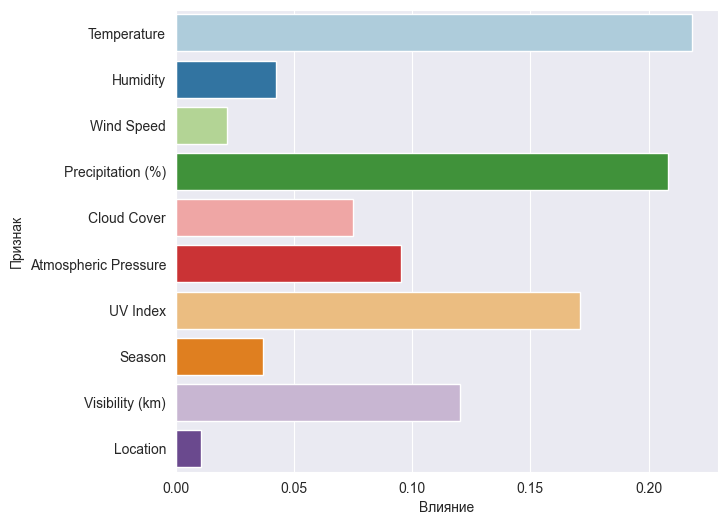

In [28]:
plt.figure(figsize=(7, 6))
sns.barplot(x='Importance', y='Feature', data=importance_score, hue='Feature', palette='Paired')
plt.xlabel('Влияние')
plt.ylabel('Признак')
plt.show()

Наибольшее влияние на классификацию оказывают температура и процент осадков, наименьшее - тип местоположения



---
Таким образом, для классификации типов погоды подходит ансамблевый классификатор - **Случайный лес**. Он имеет наибольшую точность предсказаний и отлично определяет тип погоды в зависимости от погодных явлений.


